<a href="https://colab.research.google.com/github/mgfreeman23/Pre-Semester-Winter-Project/blob/main/SarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Headlines for Sarcasm Detection


**Section 1:**
Import and Understand the Data

In [26]:
# import libraries and connect to google drive
import pandas as pd
import seaborn as sns
#metric for model performance
from sklearn.metrics import matthews_corrcoef

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# read in data from json file

df= pd.read_json('gdrive/My Drive/CAIS++/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


The number of non-sarcastic/serious news is: 14985
The number of sarcastic news is: 11724


<Axes: xlabel='is_sarcastic', ylabel='count'>

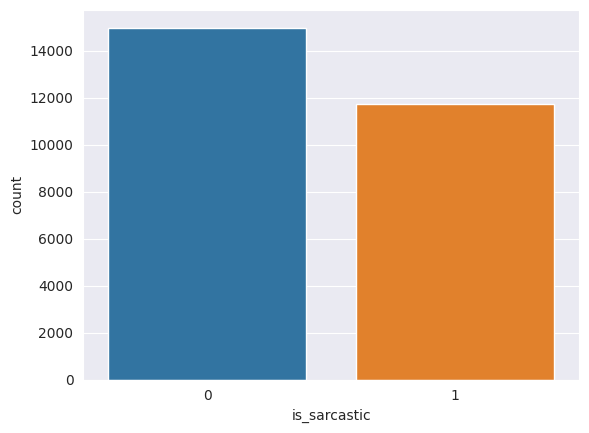

In [28]:
#determine number of sarcastic and non-sarcastic news articles

count = df['is_sarcastic'].value_counts()[0]
print(f"The number of non-sarcastic/serious news is: {count}")

count = df['is_sarcastic'].value_counts()[1]
print(f"The number of sarcastic news is: {count}")

sns.set_style("darkgrid")
sns.countplot(df, x="is_sarcastic")

In [29]:
#confirm no null values in dataset
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

**Section 2:** Prepare to Use Data with BERT

In [30]:
#ensuring we can use the Colab GPU

import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [31]:
#install transformers

!pip install transformers

In [32]:
# Get headlines and sarcastic labels as lists

headlines = df.headline.values
labels = df.is_sarcastic.values

In [33]:
#example of non-sarcastic headlines
df.loc[df.is_sarcastic == 0].sample(5)[['headline', 'is_sarcastic']]

,headline,is_sarcastic
17899,7 drawings that prove beauty is everywhere,0
16989,california city elects dead man to office afte...,0
15438,"why i voted for roy moore, twice",0
11711,oklahoma governor likens striking teachers to ...,0
15955,what the ebola virus and sen. barbara boxer ca...,0


In [34]:
#example of sarcastic headlines
df.loc[df.is_sarcastic == 1].sample(5)[['headline', 'is_sarcastic']]

,headline,is_sarcastic
2028,"cvs now selling cheaper, cvs-brand 'people' ma...",1
24765,huge animal jumps right fucking out in front o...,1
11679,conference call going awesome,1
21266,sudden resurfacing of file called 'lyrics.doc'...,1
1002,labor secretary letting 8 million unemployed a...,1


In [35]:
from transformers import BertTokenizer

# Load BERT tokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading BERT tokenizer...


In [36]:
#Example of tokenizing one headline with BERT

# Print the original headline
print(' Original: ', headlines[0])

# Print the headline split into tokens
print('Tokenized: ', tokenizer.tokenize(headlines[0]))

# Print the headline mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(headlines[0])))

 Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized:  ['former', 'versa', '##ce', 'store', 'clerk', 'sue', '##s', 'over', 'secret', "'", 'black', 'code', "'", 'for', 'minority', 'shop', '##pers']
Token IDs:  [2280, 18601, 3401, 3573, 7805, 9790, 2015, 2058, 3595, 1005, 2304, 3642, 1005, 2005, 7162, 4497, 7347]


Tokenizing the Data

In [37]:
#Find max headline length of padding/truncating to

max_len = 0

# For every sentence...
for headline in headlines:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids =  tokenizer.encode(headline, add_special_tokens = True)
    # Update the maximum sentence length.
    max_len =  max(max_len, len(input_ids)) #only updates the length when it gets a longer headline

print('Max headline length: ', max_len)

Max headline length:  66


In [38]:
# Tokenize all of the headlines and map the tokens to their word IDs using encode_plus

input_ids = []
attention_masks = []

for headline in headlines:
    #   (1) Tokenize the headline
    #   (2) Prepend the `[CLS]` token to the start
    #   (3) Append the `[SEP]` token to the end
    #   (4) Map tokens to their IDs
    #   (5) Pad or truncate the headline to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        headline,                      # Headline to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )

    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask to differentiate padding from non-padding
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', headlines[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  former versace store clerk sues over secret 'black code' for minority shoppers
Token IDs: tensor([  101,  2280, 18601,  3401,  3573,  7805,  9790,  2015,  2058,  3595,
         1005,  2304,  3642,  1005,  2005,  7162,  4497,  7347,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])


**Section 3:** Splitting into Training, Validation, and Testing Data

In [39]:
from torch.utils.data import TensorDataset, random_split

# Combine the inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train/validation to testing split

# Calculate the number of samples to include in training/validation set and testing set
train_val_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_val_size

# Divide the dataset randomly into training/validation and testing
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Repeat to split the training data into training and validation sets
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Output counts
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

21,634 training samples
2,404 validation samples
2,671 testing samples


In [40]:
#using torch DataLoader class to save memory during training -> the entire dataset won't need to be loaded into memory

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#specify batch size for the DataLoader
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order (RandomSampler)
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially (SequentialSampler)
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

**Section 4:** Fine-Tuning BERT

In [41]:
#Loading BERT

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top; ensure the model does NOT outputs attentions and hidden_states
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', output_attentions=False, output_hidden_states=False)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [42]:
#defining the optimizer with recommended learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)

In [43]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).

num_batches = train_size // batch_size;
total_steps = num_batches*epochs;

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Defining Helper Functions

In [44]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [45]:
# Function for nice formatting of elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training and Validating

In [46]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# To store training and validation loss, validation accuracy, and timings.
training_stats = []

# Total time for whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 0 the gradients
        model.zero_grad()

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent exploding gradients
        max_norm = 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    val_predictions , val_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # For calculating MCC
        val_predictions.append(logits)
        val_labels.append(label_ids)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # For validation MCC
    flat_predictions = np.concatenate(val_predictions, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_val_labels = np.concatenate(val_labels, axis=0)

    # Report the final MCC for this validation run
    mcc = matthews_corrcoef(flat_val_labels, flat_predictions)
    print('Validation MCC: %.3f' % mcc)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   100  of    677.    Elapsed: 0:00:34.
  Batch   200  of    677.    Elapsed: 0:01:09.
  Batch   300  of    677.    Elapsed: 0:01:44.
  Batch   400  of    677.    Elapsed: 0:02:19.
  Batch   500  of    677.    Elapsed: 0:02:54.
  Batch   600  of    677.    Elapsed: 0:03:29.

  Average training loss: 0.26
  Training epcoh took: 0:03:55

Running Validation...
Validation MCC: 0.852
  Accuracy: 0.93
  Validation Loss: 0.19
  Validation took: 0:00:09

======== Epoch 2 / 3 ========
Training...
  Batch   100  of    677.    Elapsed: 0:00:35.
  Batch   200  of    677.    Elapsed: 0:01:10.
  Batch   300  of    677.    Elapsed: 0:01:45.
  Batch   400  of    677.    Elapsed: 0:02:19.
  Batch   500  of    677.    Elapsed: 0:02:54.
  Batch   600  of    677.    Elapsed: 0:03:29.

  Average training loss: 0.09
  Training epcoh took: 0:03:56

Running Validation...
Validation MCC: 0.837
  Accuracy: 0.92
  Validation Loss: 0.25
  Validation took: 0:00:09


**Section 5:** Evaluating on Testing Data

In [47]:
# Creating DataLoader for our Testing Set

testing_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
print('Number of test sentences: {:,}\n'.format(test_size))

Number of test sentences: 2,671



In [48]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in testing_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,671 test sentences...
    DONE.


In [49]:
#Determining MCC

# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.870


In [51]:
# Determining accuracy

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(flat_true_labels, flat_predictions)

print('Accuracy: %.3f' % accuracy)

Accuracy: 0.935
